In [1]:
# Questdb config
DB_USER='admin'
DB_PASSWORD='quest'
DB_HOST='localhost'
DB_PORT=8812
DB_IMP_PORT=9000
DB_NAME='qdb'
DB_TRIAXIAL_OFFLOAD_TABLE_NAME='device_offload'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg
from scipy.fft import fft, fftfreq

In [3]:
def create_connection(host:str, port:str, user_name:str, password:str, database:str):
    
    """
    Create a Postgres database connection

    Parameters
    ----------
    host:str
        Database host
    port:str
        Database port
    user_name:str
        Database user name
    password:str
        Database password
    database:str
        Database name

    Returns
    -------
    A psycopg2 connection object
    """

    return pg.connect(user=user_name,
                      password=password,
                      host=host,
                      port=port,
                      database=database,
                      options='-c statement_timeout=300000')

def get_recent_triaxial_data(connection:pg.connect,
                             table_name:str,
                             sensor_name:str,
                             sample_rate:int,
                             num_seconds:float,
                             max_lookback_seconds:float):

    """
    Query the most recent data from a triaxial smartphone sensor.

    Parameters
    ----------
    connection:pg.connect
        A postgres connection object
    table_name:str
        The table where the sensor data is stored
    sensor_name:str
        The name of the sensor to query
    sample_rate:int
        The sampling rate of the sensor (in hz)
    num_seconds:float
        The number of seconds of data to pull
    max_lookback_seconds:float
        The maximum amount seconds to look for data from.
        For instance, if a device stopped producing data
        10 seconds ago, and max_lookback_seconds = 10,
        then data for this device will be ignored.

    Returns
    -------
    A DataFrame with the requested sensor data
    """

    # The number of samples to get
    num_samples:int = int(sample_rate*num_seconds)

    query:str = f"""with tmp as (select device_id,
                                       recorded_timestamp,
                                       x,
                                       y,
                                       z,
                                       row_number() over(partition by device_id order by
                                                        recorded_timestamp desc) as rn
                                        from {table_name}
                                        where sensor_name = '{sensor_name}'
                                        and recorded_timestamp::timestamp >= dateadd('s', -{int(max_lookback_seconds)}, now())
                               )

                              select * from tmp 
                              where rn <= {num_samples}
                              """

    return pd.read_sql(query, connection)

In [4]:
conn = create_connection(DB_HOST,
                         DB_PORT,
                         DB_USER,
                         DB_PASSWORD,
                         DB_NAME )

In [9]:
acc_data = get_recent_triaxial_data(conn,
                                    'device_offload',
                                    'acc',
                                     50,
                                     2,
                                     100000000)
print(acc_data.shape)
acc_data.head()

/var/folders/9r/y3yrm7yx2x31dxvgqt8pww3h0000gn/T/ipykernel_14448/3910681422.py:83: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, connection)


(101, 6)


,device_id,recorded_timestamp,x,y,z,rn
0,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-02-20 15:08:38.680784,-0.714,-0.370,0.685,100
1,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-02-20 15:08:38.680884,-0.548,-0.510,-0.032,99
2,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-02-20 15:08:38.680982,0.020,-0.611,-1.145,98
3,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-02-20 15:08:38.681078,0.226,-0.429,-1.921,97
4,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2023-02-20 15:08:38.681170,0.305,-0.352,-2.048,96


/var/folders/9r/y3yrm7yx2x31dxvgqt8pww3h0000gn/T/ipykernel_14448/3910681422.py:83: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, connection)


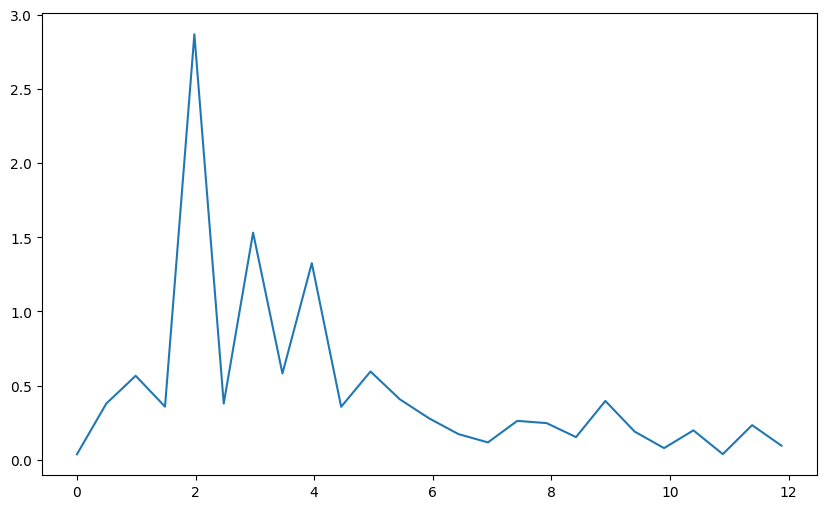

In [38]:
acc_data = get_recent_triaxial_data(conn,
                                    'device_offload',
                                    'acc',
                                     50,
                                     2,
                                     100000000)

acc_data['norm'] = np.sqrt(acc_data['x']**2 + acc_data['y']**2 + acc_data['z']**2)
    
yf = fft(acc_data['x'].values)
xf = fftfreq(len(acc_data), 1/50)[:len(acc_data)//2]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf[0:25], np.abs(yf)[:len(acc_data)//2][0:25])
plt.show()